In [67]:
import pandas as pd
import numpy as np
import math
import glob
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import cooler
from graphs import compute_HiC_graph_from_regions

In [68]:
coolerpath ={'WT':'/disk2/dh486/cooler_files/WT/manually_downsampled/KR/KR_downsampled_WT_merged_10000.cool',
             'KO':'/disk2/dh486/cooler_files/KO/KR/KR_KO_merged_10000.cool'
            }

In [69]:
def draw_circular(graph, ax, cmap = plt.cm.Blues, weightnorm = None):
    pos = nx.circular_layout(graph)
    #nx.draw_networkx_nodes(graph, pos = pos,node_size=30,ax=ax)

    edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())

    if weightnorm is None:
        weightnorm = np.percentile(weights,90)
    normalize = mpl.colors.Normalize(vmin=0, vmax=weightnorm)
    for jdx in np.argsort(weights):
        nx.draw_networkx_edges(graph, 
                           pos, 
                           ax = ax,
                           edgelist=[edges[jdx]], 
                           edge_color = cmap(normalize(weights[jdx])), 
                           connectionstyle='arc3')

    labels = {item[0]: item[1].split(":")[1].split("-")[0] for item in graph.nodes(data='bin_regions') if int(item[0])%20 == 0}
    poslabels = nx.draw_networkx_labels(graph,{key: 1.1*pos[key] for key in pos},labels = labels,ax= ax)
    
    return weightnorm, pos

def highlight_nodes(graph, nodes,ax, pos, **kwargs):
    nx.draw_networkx_nodes(graph, pos = pos,ax=ax, **kwargs)
    
def compare_gene(gene_reg, gene_name):
    gene_intregs = gene_reg.split(":")[1]
    gene_intregs = [int(item.replace(',', '')) for item in gene_intregs.split("-")]
    c = cooler.Cooler(coolerpath['WT'])
    mynodes = c.bins().fetch(gene_reg).index.values

    regions = {
        gene_reg.split(":")[0]: np.array([[gene_intregs[0]-int(4e5),gene_intregs[1]+int(4e5)]])
    }
    graphs = {cond: compute_HiC_graph_from_regions(coolerpath[cond],regions, balance = True) for cond in ['WT','KO']}

    fig, ax = plt.subplots(1,2, figsize = (16,8))
    plt.tight_layout()
    for idx in [0,1]:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['bottom'].set_visible(False)
    
    pos = {}
    KO_weightnorm,pos['KO'] = draw_circular(graphs['KO'][0],
                                        ax[0],
                                        cmap = plt.cm.Reds)
    ax[0].set_title(f"KO contacts\n{graphs['KO'][0].graph['region1']}\n{gene_name} highlighted",
                size = 15)

    nx.draw_networkx_nodes(graphs['KO'][0],
                       pos = pos['KO'],
                       ax=ax[0],
                       node_size = 50, 
                       node_color = 'yellow', 
                       nodelist = mynodes)

    WT_weightnorm, pos['WT'] = draw_circular(graphs['WT'][0],
                                         ax[1],
                                         weightnorm = KO_weightnorm)
    ax[1].set_title(f"WT contacts\n{graphs['WT'][0].graph['region1']}\n{gene_name} highlighted",
                size = 15)
    nx.draw_networkx_nodes(graphs['WT'][0],
                       pos = pos['WT'],
                       ax=ax[1],
                       node_size = 50, 
                       node_color = 'yellow', 
                       nodelist = mynodes)

    for idx in [0,1]:
        ax[idx].set_xlim([-1.3,1.2])
        ax[idx].set_ylim([-1.2,1.2])
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])

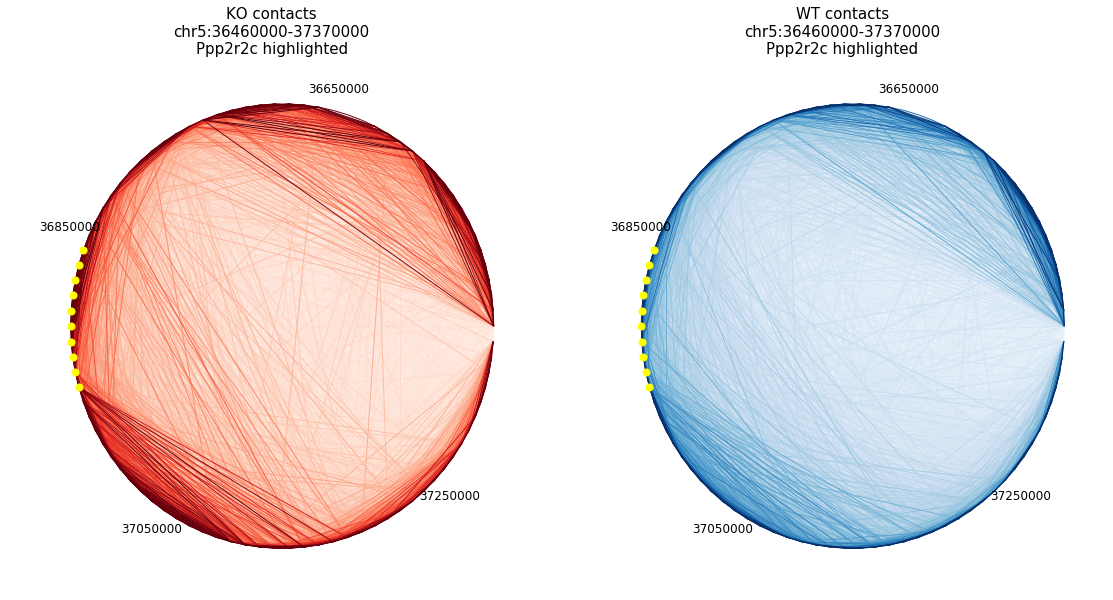

In [70]:
compare_gene(gene_reg = "chr5:36,868,513-36,955,078",gene_name = 'Ppp2r2c')

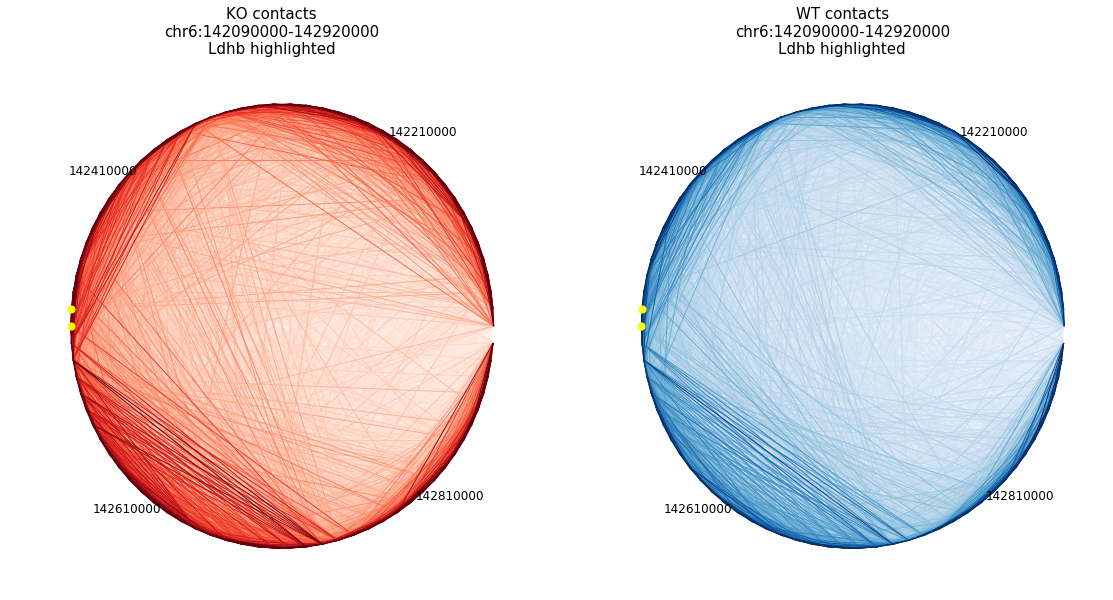

In [71]:
compare_gene(gene_reg = 'chr6:142,490,249-142,507,957',gene_name = 'Ldhb')